# NLP (Natural Language Processing) using Scikit-Learn

In [1]:
# If you still not have installed stopwords
# Uncomment the code below and run:
# import nltk # Imports the library
# nltk.download() #Download it in the manner specified in the about section

We'll be using a dataset from the UCI datasets!

The Dataset that we are using contains a collection of more than 5 thousand SMS phone messages.

Now let's use rstrip() and a list comprehension to get a list of all the lines of text messages from the dataset we have

In [2]:
#lets store that list into the variable messages
messages = [line.rstrip() for line in open('smsspamcollection/SMSSpamCollection')]
#Now lets see how many number of lines are in there in the list
print (len(messages))

5574


"corpus" is a collection of texts. Let's have a look at the first ten messages and number them using **enumerate**:

In [3]:
for message_no, message in enumerate(messages[:10]):
    print (message_no, message)
    print ('\n')

0 ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...


1 ham	Ok lar... Joking wif u oni...


2 spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's


3 ham	U dun say so early hor... U c already then say...


4 ham	Nah I don't think he goes to usf, he lives around here though


5 spam	FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, Â£1.50 to rcv


6 ham	Even my brother is not like to speak with me. They treat me like aids patent.


7 ham	As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune


8 spam	WINNER!! As a valued network customer you have been selected to receivea Â£900 prize reward! To claim call 09061701461. Claim cod

We can see that the first column is a label saying whether the given message is a normal message (commonly known as "ham") or "spam". The second column is the message itself.

lets use these labeled ham and spam examples, and **train a machine learning model to learn to discriminate between ham/spam automatically**. Then, with a trained model, we'll be able to **classify arbitrary unlabeled messages** as ham or spam.

In [4]:
import pandas

We'll use **read_csv** and make note of the **sep** argument, we can also specify the desired column names by passing in a list of *names*.

In [5]:
# By saying sep='\t' we are saying its a tab seperated 
messages = pandas.read_csv('smsspamcollection/SMSSpamCollection', sep='\t',
                           names=["label", "message"])
messages.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
messages.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


Let's use **groupby** to use describe by label, this way we can begin to think about the features that separate ham and spam!

In [7]:
messages.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

Let's make a new column to detect how long the text messages are:

In [8]:
messages['length'] = messages['message'].apply(len)
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


Let's visualize this! Let's do the imports:

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [10]:
messages.length.describe()

count    5572.000000
mean       80.489950
std        59.942907
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64

array([<AxesSubplot:title={'center':'ham'}>,
       <AxesSubplot:title={'center':'spam'}>], dtype=object)

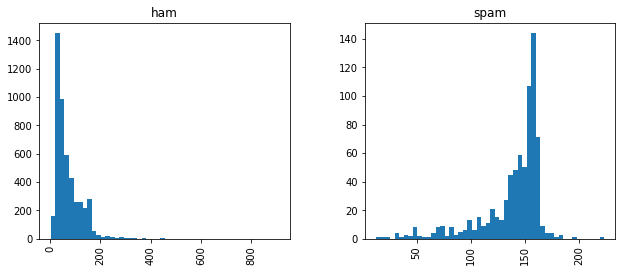

In [11]:
messages.hist(column='length', by='label', bins=50,figsize=(10,4))

So we can see the trend that spam messages tend to have more characters than that normal messages.

For us now we need to sort of numerical feature vector in order to perform the classification task. From a lsit of many methods to convert a corpus to a vector format, we will be using a simple one that is the the [bag-of-words] approach, where each unique word in a text will be represented by one number.

We'll be doing that by convert the raw messages (sequence of characters) into vectors (sequences of numbers).

In [12]:
import string
from nltk.corpus import stopwords

def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

Now let's "tokenize" messages. Tokenization is just the term used to describe the process of converting the normal text strings in to a list of tokens.

Each vector will have as many dimensions as there are unique words in the SMS corpus.  We will first use SciKit Learn's **CountVectorizer**. This model will convert a collection of text documents to a matrix of token counts.

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

There are a lot of arguments and parameters that can be passed to the CountVectorizer. In this case we will just specify the **analyzer** to be our own previously defined function:

In [14]:
bow_transformer = CountVectorizer(analyzer=text_process).fit(messages['message'])

# Print total number of vocab words
print (len(bow_transformer.vocabulary_))

11425


In [15]:
messages_bow = bow_transformer.transform(messages['message'])
print ('Shape of Sparse Matrix: ', messages_bow.shape)
print ('Amount of Non-Zero occurences: ', messages_bow.nnz)
print ('sparsity: %.2f%%' % (100.0 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1])))

Shape of Sparse Matrix:  (5572, 11425)
Amount of Non-Zero occurences:  50548
sparsity: 0.08%


In [18]:
# we will using the TfidfTransformer here
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer().fit(messages_bow)

Now Lets transform the entire bag-of-words corpus into TF-IDF corpus at once

In [19]:
messages_tfidf = tfidf_transformer.transform(messages_bow)
print (messages_tfidf.shape)

(5572, 11425)


We'll be using scikit-learn here, choosing the `Naive Bayes` classifier to start with:

In [20]:
from sklearn.naive_bayes import MultinomialNB
spam_detect_model = MultinomialNB().fit(messages_tfidf, messages['label'])

Now we'll determine how well our model is doing overall on the entire dataset.

In [21]:
all_predictions = spam_detect_model.predict(messages_tfidf)
print (all_predictions)

['ham' 'ham' 'spam' ... 'ham' 'ham' 'ham']


In [22]:
from sklearn.metrics import classification_report
print (classification_report(messages['label'], all_predictions))

              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      4825
        spam       1.00      0.85      0.92       747

    accuracy                           0.98      5572
   macro avg       0.99      0.92      0.95      5572
weighted avg       0.98      0.98      0.98      5572



Now lets split the data for validation

In [23]:
from sklearn.model_selection  import train_test_split

msg_train, msg_test, label_train, label_test = \
train_test_split(messages['message'], messages['label'], test_size=0.2)

print (len(msg_train), len(msg_test), len(msg_train) + len(msg_test))

4457 1115 5572


In [24]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

Now we can directly pass message text data and the pipeline will do our pre-processing for us! We can treat it as a model/estimator API:

In [25]:
pipeline.fit(msg_train,label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x000001CAA3FE14C0>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [26]:
predictions = pipeline.predict(msg_test)

In [27]:
print (classification_report(predictions,label_test))

              precision    recall  f1-score   support

         ham       1.00      0.95      0.98       998
        spam       0.71      1.00      0.83       117

    accuracy                           0.96      1115
   macro avg       0.86      0.98      0.90      1115
weighted avg       0.97      0.96      0.96      1115



Now we have a classification report for our model on a true testing set! 